# Статистика, DS-поток
## Практическое задание 1


**Правила:**

* Дедлайн **14 сентября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  10 баллов
* Задача 2 -  5 баллов
* Задача 3 -  5 баллов

**Важность задач:**

* *средне-высокая:* задачи 1, 2, 3;

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt

import time

%matplotlib inline

---
## Задача 1.

Реализуйте метод Монте-Карло и метод прямоугольников численного интегрирования функции. Реализация должна уметь вычислять интеграл вида:
$$ \int\limits_{l_1}^{h_1} ... \int\limits_{l_d}^{h_d} f(x_1, ... , x_d) dx_1 ... dx_d $$

*Детали реализации*: на вход функции подаются векторы $l = (l_1, ... , l_d)$ и $h = (h_1, ... ,h_d)$, число $n$ -- максимальное допустимое число вызовов функции $f$ (если вы не делаете лишних вызовов, оно равно числу точек-центров отрезков, прямоугольников, параллелипипедов, и т.д. в многомерных случаях). Использование циклов, кроме циклов по числу интегралов $d$, **наказуемо**.

Для быстрой работы метода прямоугольников мы будем использовать функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">`numpy.meshgrid`</a>. Ниже есть пример ее использования. Как всегда, настоятельно советуем читать документацию.

In [4]:
# Предположим, мы хотим получить координаты всех целых точек (x, y), 
# таких, что x лежит в промежутке [5, 6], а y - в промежутке [-3, -1]

linspace_x = [5, 6]  
linspace_y = [-3, -2, -1]

# возвращает матрицы с координатами сетки,
# задаваемой проекциями точек на оси координат
X, Y = np.meshgrid(linspace_x, linspace_y)

print("X: ", X)  # linspace_x повторилась len(linspace_y) раз по оси 0
print("Y: ", Y)  # linspace_y повторилась len(linspace_x) раз по оси 1

# преобразуем исходный формат к вектору точек
np.stack([X, Y]).reshape(2, -1).T

X:  [[5 6]
 [5 6]
 [5 6]]
Y:  [[-3 -3]
 [-2 -2]
 [-1 -1]]


array([[ 5, -3],
       [ 6, -3],
       [ 5, -2],
       [ 6, -2],
       [ 5, -1],
       [ 6, -1]])

In [5]:
class Integrator:
    
    @staticmethod
    def integrate(f, low, high, n, method="rectangle"):
        """
        Вычисление определенного интеграла.
        
        Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
        n --- максимальное число вызовов функции f.
        method --- метод ("rectangle" или "monte_carlo").
                            
        Возвращает приближенное значение интеграла.
        """
        
        assert len(low) == len(high)
        low, high = map(np.array, [low, high])
        
        n = int(n)

        return Integrator.methods[method](f, low, high, n)
    
    
    def integrate_monte_carlo(f, low, high, n):
        """Метод монте-карло"""
        
        dim = len(high)
        dots =  np.random.uniform(low,high,size=(n,dim))
        
        diff =  high-low
    
        
        return (f(dots).sum())/n*np.prod(diff)
    
    
    def integrate_rectangle(f, low, high, n):
        """Метод прямоугольников"""
        
        dim = len(high)
        
        n_rounded =  int(pow(n, 1/dim))
        
        diff =  (high-low)/n_rounded

        centers_of_ranges = np.zeros((dim, n_rounded))
        
        # для каждой размерности найдите центры отрезков разбиения
        for i in range(dim):
            array_points=np.linspace(low[i], high[i], n_rounded+1)-diff[i]/2
            centers_of_ranges[i]=np.delete(array_points,0)
        
        centers = np.meshgrid(*centers_of_ranges)
        f_vals = f(np.stack(centers).reshape(dim, -1).T)
        return f_vals.sum() * np.prod(diff)
    
    def integrate_rectangle_exact(f, low, high, n):
        """Метод прямоугольников, но слегка более точный для больших dim"""
        #расстягивает сетку из квадрата до прямуогольника, чтобы кол-во точек было меньше n, но максимально возможным
        
        dim = len(high)
        
        n_rounded_min =  pow(n, 1/dim)
        n_rounded=np.array([int(n_rounded_min) for i in range(dim)])
        
        #попробуем увеличить для некоторых плоскостей (где больше диапозон high-low)
        array_index_increase=(np.argsort((high-low)))[::-1]
        if (n_rounded_min>int(n_rounded_min)):
            #значит мы в какой-то плоскости возможно сможем увеличить кол-во точек на 1
            prod=np.prod(n_rounded)
            for i in range(dim):
                prod=prod/n_rounded[array_index_increase[i]]*(n_rounded[array_index_increase[i]]+1)
                if (prod<=n):
                    n_rounded[array_index_increase[i]]+=1
                else:
                    break
    
        diff =  (high-low)/n_rounded
        
        centers_of_ranges=[]
        
        # для каждой размерности найдите центры отрезков разбиения
        for i in range(dim):
            array_points=np.linspace(low[i], high[i], n_rounded[i]+1)-diff[i]/2
            centers_of_ranges.append(np.delete(array_points,0))
        centers_of_ranges=np.array(centers_of_ranges)
        
        
        centers = np.meshgrid(*centers_of_ranges)
        f_vals = f(np.stack(centers).reshape(dim, -1).T)
        return f_vals.sum() * np.prod(diff)
    
    
    methods = {
        "rectangle": integrate_rectangle,
        "monte_carlo": integrate_monte_carlo,
        "rectangle_exact":integrate_rectangle_exact
    }


Вычислите $\int\limits_0^1 \int\limits_3^4 \left(x^2 + y^2\right) dxdy$ на миллионе запусков функции $f(x, y) = x^2+y^2$ двумя рассмотренными методами. Измерьте время работы методов и сравните результат с истинными значением интеграла. Различается ли время работы методов? Объясните результаты с точки зрения теории.

In [6]:
square_sum = lambda x: np.sum(x**2, axis=1)

In [7]:
count=10**6
integral=Integrator

start_time = time.time()
res_rectangle=integral.integrate(square_sum,[0,3],[1,4],count)
print("Время вычисления интеграла методом прямоугольника равно %s секунд." % (time.time() - start_time))
print("Интеграл={}".format(res_rectangle))

Время вычисления интеграла методом прямоугольника равно 0.03490614891052246 секунд.
Интеграл=12.6666665


Так как сount=1000000,а корень это 1000, то у rectangle нет проблем с окргулением вниз, результат будет совпадать с rectangle_exact

In [8]:
start_time = time.time()
res_monte_carlo=integral.integrate(square_sum,[0,3],[1,4],count,"monte_carlo")
print("Время вычисления интеграла методом Монте-Карло равно %s секунд." % (time.time() - start_time))
print("Интеграл={}".format(res_monte_carlo))

Время вычисления интеграла методом Монте-Карло равно 0.06583237648010254 секунд.
Интеграл=12.663982151381845


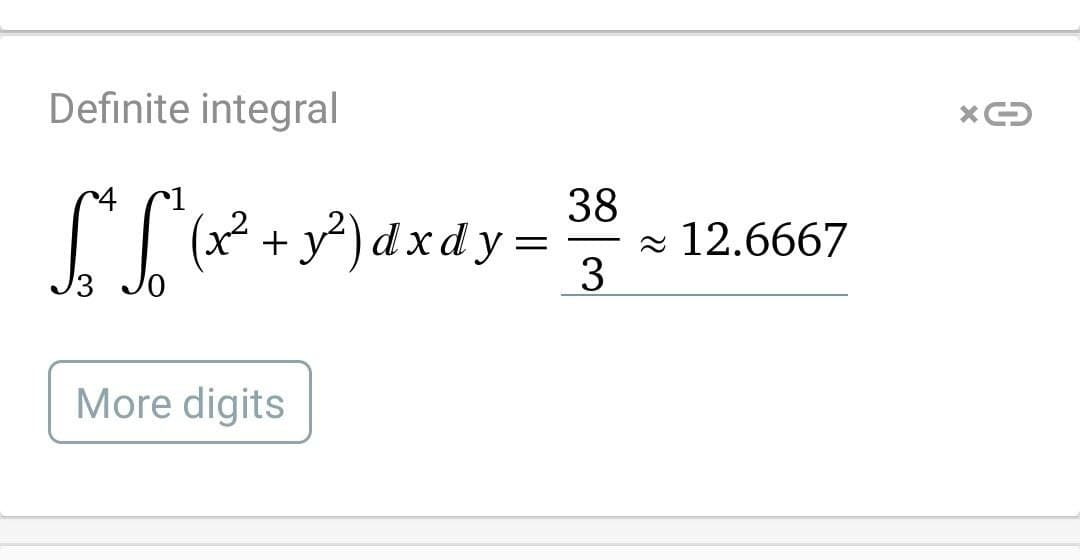

In [9]:
#Мы вычислили нужный нам интеграл с помощью вольфрама, получили ответ 38/3. 
#Cравним результаты
correct_res=38/3
print("abs(correct_res-res_rectangle)={}".format(abs(correct_res-res_rectangle)))
print("abs(correct_res-res_monte_carlo)={}".format(abs(correct_res-res_monte_carlo)))

abs(correct_res-res_rectangle)=1.6666666624587378e-07
abs(correct_res-res_monte_carlo)=0.002684515284821387


**Вывод** Как мы заметили, метод прямоугольников дает более в разы более точный ответ, также метод Монте-Карло зависит от распределения точек, соответсвенно на разном разбиении он будет показывать разные ответы.
Также нам известно из теории, что при больших размерностях метод Монте-Карло будет работать быстрее методотов прямоугольников (будет быстрее сгенерировать точки, чем разбивать на отрезки и затем искать их середины).
Но при наших условиях, метод Монте-Карло работает намного медленнее.
Это может бысть связано с тем, что размерность d=2 маленькая и нам некритично искать середины отрезков, в то время как генерировать точки в Монте-Карло довольно затратно. Так как при любом d, генерация точек в Монте-Карло зависит только от их количества, в то время, как в методе прямоугольников генерация середин отрезков и самих отрезков(diff) зависит от размерности пространства ($n_{rounded}^d=n$)

---
## Задача 2.

Для $d = 1...8$ оцените скорость сходимости методов для интеграла
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i$$

Т.е. $\int\limits_0^1 x_1^2 dx_1$, $\int\limits_0^1 \int\limits_0^1 \left( x_1^2 + x_2^2 \right) dx_1 dx_2$ и так далее.

Вычислите точное значение этого интеграла и для каждого $d$ постройте график зависимости вычисленного значения интеграла от числа $n$ вызовов подынтегральной функции (в корректном решении равно числу точек-центров), которое разрешено использовать для каждого метода вычисления интеграла. Рекомендуется рассмотреть значения $n$ вплоть до $d \times 1000$.

Для вашего удобства, мы написали функцию, которая строит графики в этой задаче.

In [10]:
max_dim = 8


def plot_convergence(f, low, high, n_list, theoretical_value, max_dim):
    """
    Построение графиков сходимости методов Монте-Карло и прямоугольников.
    
    Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
    n_list --- список.
    theoretical_value --- точное значение интеграла.
    max_dim --- максимальная кратность интеграла.
    """
    
    source = np.arange(max_dim) + 1
    i = Integrator()
    
    for d in source:
        rectangles_computed = np.zeros(len(n_list))
        monte_carlo_computed = np.zeros(len(n_list))
        
        rectangle_exact_computed=np.zeros(len(n_list))
        
        for n in np.arange(len(n_list)):
            mn = i.integrate(f, low[:d], high[:d], n_list[n],
                             method="monte_carlo")
            rc = i.integrate(f, low[:d], high[:d], n_list[n])
            
            rce=i.integrate(f, low[:d], high[:d], n_list[n],
                             method="rectangle_exact")
            
            monte_carlo_computed[n] = mn
            rectangles_computed[n] = rc
            rectangle_exact_computed[n]=rce
        plt.figure(figsize=(15, 5))
        plt.title('Зависимость вычисленного значения интеграла' +
                  ' от n для d = {}'.format(d), fontsize=14)      
        plt.xlabel("Число вызовов функции", fontsize=14)
        plt.ylabel("Значение интеграла", fontsize=14)
        plt.plot(n_list, monte_carlo_computed, color='blue',
                 label="по методу Монте-Карло")
        plt.plot(n_list, rectangles_computed, color='magenta',
                 label="по методу прямоугольников")
        plt.axhline(y=theoretical_value[d - 1], color='indigo',
                    linestyle='--', label="истинное значение")
        
        #добавляю свой метод прямоугольника, который должен быть более точным
        plt.plot(n_list, rectangle_exact_computed, color='green',
                 label="по методу прямоугольников(более точная реализация)")
        
        plt.legend(fontsize=14)

In [ ]:
low=np.zeros(max_dim)
high=np.ones(max_dim)
theoretical_value=np.arange(1/3,8/3+1,1/3)#вольфрам
n_list=np.arange(10,max_dim*1000)

plot_convergence(square_sum,low,high,n_list,theoretical_value,max_dim)

<ipython-input-5-cdd8c27e7bc7>:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centers_of_ranges=np.array(centers_of_ranges)
<ipython-input-5-cdd8c27e7bc7>:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centers_of_ranges=np.array(centers_of_ranges)


Какой метод и при каких $d$ сходится быстрее? Предположите, в каком случае выгоднее использовать тот или иной метод.

С чем связано такое поведение графиков?

Сравните результаты с предыдущей задачей.

**Вывод:** При d=1,2,3 метод прямоугольника сходится быстрее и он более близок к истинному значению. Но затем при увеличении d метод прямоугольника значительно проигрывает Монте-Карло. Причем это заключается не только в скорости "схождения", но и в точности. Это связано с тем, что в Монте-Карло мы всегда берем ровно n точек, а в методе прямоугольников в одной плокости мы берем $n^{1/d}$ точек, что  мало (по сравнению с Монте-Карло) и тогда неточный результат получается. Также прекрасно видно, что Монте-Карло всегда хватает достаточно маленьких n, чтобы приблиться к истинному значению, в то время, как методу прямоугольников нужно больше точек для хорошей точности.

Также я нарисовал (зеленый) метод прямоугольников, который слегка более точный (использует больше точек), это дает улучшение, но не всегда и негромадное. Оно слегка улучшает обычный метод прямоугольников, но не приближает его к результатам Монте-Карло, так как оно разные по идеи.

В 1 задаче у нас было 1000000 точек и d=2, то есть 1000 точек в одной плоскости, тут же <=8000 точек, а 1<=d<=8, намного меньше точек в одной плоскости получается. Поэтому такие разные результаты в 1 и во 2 номере.
    
   
 Получается, что для оценки значения интеграла (довольно точного, так как сходится уже при маленьких n) лучше использовать метод Монте-Карло, в остальных случаях метод прямоугольника. То есть ли у нас есть большое количество точек, но мы сможем получить хороший гарантированный результат с помощью метода прямоугольника, хоть и за более большое время. 

---
## Задача 3.

Вам предлагается численно посчитать многомерный интеграл Пуассона для размерности $d=5$ и некоторой симметричной положительно определенной матрицы $A$, которую вы выберете сами. Зависит ли интеграл от выбора $A$? 
$$\int\limits_{\mathbb{R}^d} exp( - x^T A x) dx $$

Сравните результаты двух методов с истинным значением интеграла. Как вы думаете, какой метод выдает более точный результат? Количество итераций каждого метода должно быть не менее $10^6$. Теоретическое вычисление интеграла можно не приводить, достаточно написать ответ.

**Комментарий:** В этой задаче особенно важно выбрать правильные пределы интегрирования. 
Например, для единичной матрицы достаточно взять интеграл с пределами внутри области $[-5, 5]^5$

В связи с этим просим Вас ответить на наводящие вопросы. 
1. Что будет, если выбрать слишком большие пределы в методе Монте-Карло? 
2. Что может произойти, если выбрать слишком большие пределы в методе прямоугольников?

В этой задаче нельзя использовать циклы. Для вычисления функции в точках используете простые векторно-матричные операции в `numpy`.

In [211]:
#возмем A=diag(1,1,1,1,1)
#тогда интеграл будет задаваться такой формулой
gaussian_integral = lambda x: np.prod(np.exp(-(x**2)), axis=1)
count=10**7
low=np.array([-5,-5,-5,-5,-5])
high=np.array([5,5,5,5,5])
res_rectangle=integral.integrate(gaussian_integral,low,high,count)
res_rectangle

17.4934183275526

In [212]:
res_monte_carlo=integral.integrate(gaussian_integral,low,high,count, "monte_carlo")
res_monte_carlo

17.726660797490336

In [213]:
import math
#Эталонное значение равно 17.493418327490385
reference_solution=(math.erf(5)*math.sqrt(math.pi))**5

print("abs(reference_solution-res_rectangle)={}".format(abs(reference_solution-res_rectangle)))
print("abs(reference_solution-res_monte_carlo)={}".format(abs(reference_solution-res_monte_carlo)))

abs(reference_solution-res_rectangle)=6.221512194315437e-11
abs(reference_solution-res_monte_carlo)=0.23324246999995069


**Вывод** Конечно интеграл зависит от матрицы A, это понятно, так как x^TAx скаляр, а вот коэффиенты его координат зависят от А, также мы можем посчитать теориетически значение данного интеграла. Так как можно заметить, что это похоже на плотность нормального распределения.

Видно, что метод прямоугольника на много разрядов точнее, так как у нас размерность всего 5, а точек и мы используем много (нет проблем 2 задачи).


In [214]:
#Теперь рассмотрим, что будет, если выбрать слишком большой диапазон
low*=1000
high*=1000
res_rectangle=integral.integrate(gaussian_integral,low,high,count)
res_monte_carlo=integral.integrate(gaussian_integral,low,high,count, "monte_carlo")
print("Результаты res_rectangle и res_monte_carlo равны, соответственно",res_rectangle,"и",res_monte_carlo)

Результаты res_rectangle и res_monte_carlo равны, соответственно 10240000000000.0 и 0.0


Как видно, значение метода прямоугольника стремятся к бесконечности (большому числу), в то время, как у Монте-Карло стремится к 0.
Давайте объясню это, для начала надо рассмотреть $$exp(-x^2).$$

Если нарисовать график, то мы увидим "холмик" при x от -2 до 2, в остальных тчоках функция будет стремиться к 0. То есть наша функция почти во всех точках стремится к 0, кроме довольно узкой области, где значения сильно отличаются от 0.

В методе Монте-Карло из-за равномерного распределения, мы получим, что малое количество точек сможет попасть в нужную узкую область, тогда функция в большинстве точек будет принимать значение около 0, и весь интеграл тоже будет стремиться к 0.

В это же время, в методе прямоугольника мы делим нашу область на равные части, то есть мы гарантируем, что часть точек попадет в узкую область, также у нас в интеграле есть коэффициент $np.prod(diff)$, а так мы берем большой диапазон, то и этот коэффициент будет большим, из-за этого наш результат стремится к бесконечости. 

Рассмотрим отношение интегралов: 
$$
F(t) = \frac{ \int\limits_{-\infty}^{t_1} ... \int\limits_{-\infty}^{t_k} exp \left( - \frac12 x^T A x \right) dx}{ \int\limits_{\mathbb{R}^n} exp \left( - \frac12 x^T A x \right) dx}.
$$
В чем его вероятностный смысл?

Если n=k, то это функция распределения многомерного нормального распределения, так как в числители мы берем n интегралов от плотности многомерного нормального распределения, а знаменатель-это нормировка, так как функция распределения должна быть $<=1$. Если же n>k, то это похоже на какую-то хитрую плотность